# Solving cartpole task with policy-based RL algorithms

**Decription of the task:**
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
import agents

# Vanilla Policy-Gradient 

In [130]:
from importlib import reload
reload(agents)

<module 'agents' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/agents.py'>

In [131]:
def play_episode(agent, env, return_states=False, greedy=True):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    done = []
    
    if return_states:
        states = [state]
        
    steps = 0
    while True:
        action, log_prob = agent.get_action(state, return_log = True, greedy=greedy)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        
        if return_states:
            states.append(new_state)
            
        #if terminal and 'TimeLimit.truncated' not in info:
        #    reward = -1
            
        rewards.append(reward)
        log_probs.append(log_prob)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
       
    rewards = np.array(rewards)
    log_probs = np.array(log_probs)
    done = np.array(done)
    
    if return_states:
        return rewards, log_probs, np.array(states), done
    else:
        return rewards, log_probs, done

In [132]:
def train_cartpole(n_episodes = 100, lr = 0.01, gamma = 0.99, greedy=False):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = agents.PolicyGrad(observation_space, action_space, lr, gamma)
    performance = []
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, _ = play_episode(agent, env, greedy=greedy)
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-10:])))
        
        loss = agent.update(rewards, log_probs)
        losses.append(loss)
    return agent, np.array(performance), np.array(losses)

In [133]:
%%time
trained_agentPG, cumulative_rewardPG, lossesPG = train_cartpole(n_episodes = 500, lr=5e-3)

Episode 10 - reward: 20
Episode 20 - reward: 28
Episode 30 - reward: 27
Episode 40 - reward: 29
Episode 50 - reward: 30
Episode 60 - reward: 38
Episode 70 - reward: 62
Episode 80 - reward: 136
Episode 90 - reward: 103
Episode 100 - reward: 409
Episode 110 - reward: 408
Episode 120 - reward: 32
Episode 130 - reward: 17
Episode 140 - reward: 90
Episode 150 - reward: 270
Episode 160 - reward: 406
Episode 170 - reward: 14
Episode 180 - reward: 14
Episode 190 - reward: 17
Episode 200 - reward: 24
Episode 210 - reward: 63
Episode 220 - reward: 252
Episode 230 - reward: 449
Episode 240 - reward: 500
Episode 250 - reward: 500
Episode 260 - reward: 109
Episode 270 - reward: 9
Episode 280 - reward: 9
Episode 290 - reward: 9
Episode 300 - reward: 10
Episode 310 - reward: 9
Episode 320 - reward: 9
Episode 330 - reward: 10
Episode 340 - reward: 9
Episode 350 - reward: 9
Episode 360 - reward: 10
Episode 370 - reward: 9
Episode 380 - reward: 9
Episode 390 - reward: 10
Episode 400 - reward: 9
Episode 

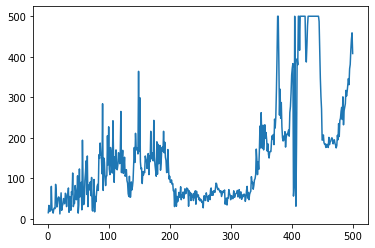

In [96]:
episodes = np.arange(1,len(cumulative_rewardPG)+1)
plt.plot(episodes, cumulative_rewardPG)
plt.show()

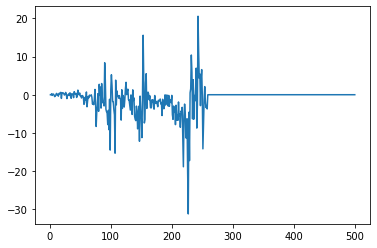

In [134]:
plt.plot(episodes, lossesPG)
plt.show()

In [97]:
def render_test_episode(agent):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    state = env.reset()
    while True:
        env.render()
        action = agent.get_action(state, return_log = False, greedy=False)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        if terminal: 
            break
        else: 
            state = new_state
    env.close()

In [98]:
render_test_episode(trained_agentPG) 

# Advantage Actor-Critic - Step update version

In [107]:
from importlib import reload
reload(agents)

<module 'agents' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/agents.py'>

In [108]:
def train_cartpole_A2C_v0(n_epochs = 100, lr_actor = 0.01, lr_critic = 0.01, gamma = 0.99, greedy=False):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = agents.A2C_v0(observation_space, action_space, lr_actor, lr_critic, gamma)
    performance = []
    for e in range(n_epochs):
        # Reset environment (start of an episode)
        state = env.reset()
        rewards = []

        steps = 0
        while True:
            action, log_prob = agent.get_action(state, return_log = True, greedy=greedy)
            new_state, reward, terminal, info = env.step(action) # gym standard step's output

            #if terminal and 'TimeLimit.truncated' not in info:
            #    reward = -1

            rewards.append(reward)
            agent.update(reward, log_prob, state, new_state, terminal)
            
            if terminal:
                break

            state = new_state
            
            
        rewards = np.array(rewards)
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-10:])))

    return agent, np.array(performance)

In [109]:
%%time
agent, performance = train_cartpole_A2C_v0(n_epochs=500, lr_actor=5e-2, lr_critic=5e-3)

A  tensor(0.9597, grad_fn=<SubBackward0>)
A  tensor(0.9540, grad_fn=<SubBackward0>)
A  tensor(0.9546, grad_fn=<SubBackward0>)
A  tensor(0.9569, grad_fn=<SubBackward0>)
A  tensor(1.0408, grad_fn=<SubBackward0>)
A  tensor(0.9540, grad_fn=<SubBackward0>)
A  tensor(0.9569, grad_fn=<SubBackward0>)
A  tensor(0.9518, grad_fn=<SubBackward0>)
A  tensor(1.0464, grad_fn=<SubBackward0>)
A  tensor(0.9376, grad_fn=<SubBackward0>)
A  tensor(1.0509, grad_fn=<SubBackward0>)
A  tensor(1.2408, grad_fn=<SubBackward0>)
A  tensor(1.0757, grad_fn=<SubBackward0>)
A  tensor(1.0498, grad_fn=<SubBackward0>)
A  tensor(0.9510, grad_fn=<SubBackward0>)
A  tensor(1.0356, grad_fn=<SubBackward0>)
A  tensor(0.9638, grad_fn=<SubBackward0>)
A  tensor(1.0238, grad_fn=<SubBackward0>)
A  tensor(1.0102, grad_fn=<SubBackward0>)
A  tensor(0.9887, grad_fn=<SubBackward0>)
A  tensor(0.9915, grad_fn=<SubBackward0>)
A  tensor(0.9788, grad_fn=<SubBackward0>)
A  tensor(1.0162, grad_fn=<SubBackward0>)
A  tensor(0.7202, grad_fn=<SubBack

A  tensor(0.9458, grad_fn=<SubBackward0>)
A  tensor(0.9387, grad_fn=<SubBackward0>)
A  tensor(1.0279, grad_fn=<SubBackward0>)
A  tensor(0.9380, grad_fn=<SubBackward0>)
A  tensor(1.0245, grad_fn=<SubBackward0>)
A  tensor(1.0050, grad_fn=<SubBackward0>)
A  tensor(0.9849, grad_fn=<SubBackward0>)
A  tensor(-0.6034, grad_fn=<SubBackward0>)
A  tensor(0.9964, grad_fn=<SubBackward0>)
A  tensor(0.9720, grad_fn=<SubBackward0>)
A  tensor(0.9850, grad_fn=<SubBackward0>)
A  tensor(0.9533, grad_fn=<SubBackward0>)
A  tensor(0.9375, grad_fn=<SubBackward0>)
A  tensor(0.9289, grad_fn=<SubBackward0>)
A  tensor(0.9105, grad_fn=<SubBackward0>)
A  tensor(1.0361, grad_fn=<SubBackward0>)
A  tensor(0.8870, grad_fn=<SubBackward0>)
A  tensor(1.0456, grad_fn=<SubBackward0>)
A  tensor(1.0485, grad_fn=<SubBackward0>)
A  tensor(1.0587, grad_fn=<SubBackward0>)
A  tensor(1.0534, grad_fn=<SubBackward0>)
A  tensor(0.8668, grad_fn=<SubBackward0>)
A  tensor(0.8591, grad_fn=<SubBackward0>)
A  tensor(1.0448, grad_fn=<SubBac

A  tensor(0.6836, grad_fn=<SubBackward0>)
A  tensor(1.1930, grad_fn=<SubBackward0>)
A  tensor(0.6769, grad_fn=<SubBackward0>)
A  tensor(1.1789, grad_fn=<SubBackward0>)
A  tensor(-0.2430, grad_fn=<SubBackward0>)
Episode 20 - reward: 20
A  tensor(0.7826, grad_fn=<SubBackward0>)
A  tensor(0.7191, grad_fn=<SubBackward0>)
A  tensor(0.6918, grad_fn=<SubBackward0>)
A  tensor(1.2216, grad_fn=<SubBackward0>)
A  tensor(0.6777, grad_fn=<SubBackward0>)
A  tensor(1.2156, grad_fn=<SubBackward0>)
A  tensor(0.6675, grad_fn=<SubBackward0>)
A  tensor(1.2050, grad_fn=<SubBackward0>)
A  tensor(1.1976, grad_fn=<SubBackward0>)
A  tensor(1.1796, grad_fn=<SubBackward0>)
A  tensor(1.1458, grad_fn=<SubBackward0>)
A  tensor(1.0549, grad_fn=<SubBackward0>)
A  tensor(0.8599, grad_fn=<SubBackward0>)
A  tensor(1.0668, grad_fn=<SubBackward0>)
A  tensor(0.8432, grad_fn=<SubBackward0>)
A  tensor(1.0805, grad_fn=<SubBackward0>)
A  tensor(0.8253, grad_fn=<SubBackward0>)
A  tensor(0.7566, grad_fn=<SubBackward0>)
A  tensor

A  tensor(1.0931, grad_fn=<SubBackward0>)
A  tensor(0.8429, grad_fn=<SubBackward0>)
A  tensor(1.1124, grad_fn=<SubBackward0>)
A  tensor(0.9228, grad_fn=<SubBackward0>)
A  tensor(0.8970, grad_fn=<SubBackward0>)
A  tensor(0.8782, grad_fn=<SubBackward0>)
A  tensor(0.9744, grad_fn=<SubBackward0>)
A  tensor(0.8467, grad_fn=<SubBackward0>)
A  tensor(0.9817, grad_fn=<SubBackward0>)
A  tensor(0.8261, grad_fn=<SubBackward0>)
A  tensor(0.9710, grad_fn=<SubBackward0>)
A  tensor(0.8236, grad_fn=<SubBackward0>)
A  tensor(0.8010, grad_fn=<SubBackward0>)
A  tensor(0.7661, grad_fn=<SubBackward0>)
A  tensor(0.7130, grad_fn=<SubBackward0>)
A  tensor(0.2421, grad_fn=<SubBackward0>)
Episode 30 - reward: 23
A  tensor(0.8546, grad_fn=<SubBackward0>)
A  tensor(1.0847, grad_fn=<SubBackward0>)
A  tensor(0.8339, grad_fn=<SubBackward0>)
A  tensor(1.0982, grad_fn=<SubBackward0>)
A  tensor(0.8163, grad_fn=<SubBackward0>)
A  tensor(1.1344, grad_fn=<SubBackward0>)
A  tensor(0.7974, grad_fn=<SubBackward0>)
A  tensor(

A  tensor(0.9347, grad_fn=<SubBackward0>)
A  tensor(1.0009, grad_fn=<SubBackward0>)
A  tensor(0.9058, grad_fn=<SubBackward0>)
A  tensor(1.0849, grad_fn=<SubBackward0>)
A  tensor(0.9443, grad_fn=<SubBackward0>)
A  tensor(0.8647, grad_fn=<SubBackward0>)
A  tensor(0.8331, grad_fn=<SubBackward0>)
A  tensor(0.7850, grad_fn=<SubBackward0>)
A  tensor(0.7459, grad_fn=<SubBackward0>)
A  tensor(0.9617, grad_fn=<SubBackward0>)
A  tensor(0.9773, grad_fn=<SubBackward0>)
A  tensor(1.0052, grad_fn=<SubBackward0>)
A  tensor(1.0250, grad_fn=<SubBackward0>)
A  tensor(1.0415, grad_fn=<SubBackward0>)
A  tensor(0.8597, grad_fn=<SubBackward0>)
A  tensor(0.8065, grad_fn=<SubBackward0>)
A  tensor(0.7688, grad_fn=<SubBackward0>)
A  tensor(0.9643, grad_fn=<SubBackward0>)
A  tensor(0.7524, grad_fn=<SubBackward0>)
A  tensor(0.9515, grad_fn=<SubBackward0>)
A  tensor(0.9776, grad_fn=<SubBackward0>)
A  tensor(-0.4527, grad_fn=<SubBackward0>)
A  tensor(0.8431, grad_fn=<SubBackward0>)
A  tensor(1.0757, grad_fn=<SubBac

A  tensor(1.1473, grad_fn=<SubBackward0>)
A  tensor(1.0122, grad_fn=<SubBackward0>)
A  tensor(0.9004, grad_fn=<SubBackward0>)
A  tensor(0.9874, grad_fn=<SubBackward0>)
A  tensor(0.9246, grad_fn=<SubBackward0>)
A  tensor(0.9599, grad_fn=<SubBackward0>)
A  tensor(0.9044, grad_fn=<SubBackward0>)
A  tensor(0.8474, grad_fn=<SubBackward0>)
A  tensor(0.7179, grad_fn=<SubBackward0>)
A  tensor(0.6323, grad_fn=<SubBackward0>)
A  tensor(0.5489, grad_fn=<SubBackward0>)
A  tensor(0.4606, grad_fn=<SubBackward0>)
A  tensor(0.3741, grad_fn=<SubBackward0>)
A  tensor(0.2253, grad_fn=<SubBackward0>)
A  tensor(0.8302, grad_fn=<SubBackward0>)
A  tensor(0.7639, grad_fn=<SubBackward0>)
A  tensor(0.6248, grad_fn=<SubBackward0>)
A  tensor(1.0440, grad_fn=<SubBackward0>)
A  tensor(1.0768, grad_fn=<SubBackward0>)
A  tensor(0.6448, grad_fn=<SubBackward0>)
A  tensor(0.5529, grad_fn=<SubBackward0>)
A  tensor(0.4674, grad_fn=<SubBackward0>)
A  tensor(0.3739, grad_fn=<SubBackward0>)
A  tensor(0.3245, grad_fn=<SubBack

A  tensor(0.8706, grad_fn=<SubBackward0>)
A  tensor(1.0747, grad_fn=<SubBackward0>)
A  tensor(0.8431, grad_fn=<SubBackward0>)
A  tensor(1.0813, grad_fn=<SubBackward0>)
A  tensor(1.0732, grad_fn=<SubBackward0>)
A  tensor(0.9853, grad_fn=<SubBackward0>)
A  tensor(0.8897, grad_fn=<SubBackward0>)
A  tensor(0.8242, grad_fn=<SubBackward0>)
A  tensor(0.7709, grad_fn=<SubBackward0>)
A  tensor(0.8540, grad_fn=<SubBackward0>)
A  tensor(0.7001, grad_fn=<SubBackward0>)
A  tensor(0.7999, grad_fn=<SubBackward0>)
A  tensor(0.6580, grad_fn=<SubBackward0>)
A  tensor(0.8170, grad_fn=<SubBackward0>)
A  tensor(0.6450, grad_fn=<SubBackward0>)
A  tensor(0.5885, grad_fn=<SubBackward0>)
A  tensor(0.7107, grad_fn=<SubBackward0>)
A  tensor(0.7515, grad_fn=<SubBackward0>)
A  tensor(0.5485, grad_fn=<SubBackward0>)
A  tensor(-1.1938, grad_fn=<SubBackward0>)
A  tensor(0.9969, grad_fn=<SubBackward0>)
A  tensor(0.9840, grad_fn=<SubBackward0>)
A  tensor(1.1115, grad_fn=<SubBackward0>)
A  tensor(0.9048, grad_fn=<SubBac

A  tensor(0.8531, grad_fn=<SubBackward0>)
A  tensor(0.3643, grad_fn=<SubBackward0>)
A  tensor(0.8977, grad_fn=<SubBackward0>)
A  tensor(0.7806, grad_fn=<SubBackward0>)
A  tensor(0.8175, grad_fn=<SubBackward0>)
A  tensor(0.8464, grad_fn=<SubBackward0>)
A  tensor(1.9857, grad_fn=<SubBackward0>)
A  tensor(0.5407, grad_fn=<SubBackward0>)
A  tensor(1.2675, grad_fn=<SubBackward0>)
A  tensor(0.4785, grad_fn=<SubBackward0>)
A  tensor(0.2175, grad_fn=<SubBackward0>)
A  tensor(0.0124, grad_fn=<SubBackward0>)
A  tensor(-0.1382, grad_fn=<SubBackward0>)
A  tensor(0.8523, grad_fn=<SubBackward0>)
A  tensor(0.1013, grad_fn=<SubBackward0>)
A  tensor(0.6991, grad_fn=<SubBackward0>)
A  tensor(0.8283, grad_fn=<SubBackward0>)
A  tensor(0.8683, grad_fn=<SubBackward0>)
A  tensor(1.3160, grad_fn=<SubBackward0>)
A  tensor(1.0002, grad_fn=<SubBackward0>)
A  tensor(0.8871, grad_fn=<SubBackward0>)
A  tensor(0.8523, grad_fn=<SubBackward0>)
A  tensor(0.7741, grad_fn=<SubBackward0>)
A  tensor(0.7114, grad_fn=<SubBac

A  tensor(0.9645, grad_fn=<SubBackward0>)
A  tensor(0.9797, grad_fn=<SubBackward0>)
A  tensor(0.7253, grad_fn=<SubBackward0>)
A  tensor(0.8862, grad_fn=<SubBackward0>)
A  tensor(0.9645, grad_fn=<SubBackward0>)
A  tensor(0.9183, grad_fn=<SubBackward0>)
A  tensor(0.9558, grad_fn=<SubBackward0>)
A  tensor(0.9041, grad_fn=<SubBackward0>)
A  tensor(0.6936, grad_fn=<SubBackward0>)
A  tensor(0.5156, grad_fn=<SubBackward0>)
A  tensor(0.3242, grad_fn=<SubBackward0>)
A  tensor(0.1043, grad_fn=<SubBackward0>)
A  tensor(0.2956, grad_fn=<SubBackward0>)
A  tensor(0.1707, grad_fn=<SubBackward0>)
A  tensor(0.3229, grad_fn=<SubBackward0>)
A  tensor(0.1898, grad_fn=<SubBackward0>)
A  tensor(0.2167, grad_fn=<SubBackward0>)
A  tensor(0.8166, grad_fn=<SubBackward0>)
A  tensor(0.6949, grad_fn=<SubBackward0>)
A  tensor(1.1223, grad_fn=<SubBackward0>)
A  tensor(0.6015, grad_fn=<SubBackward0>)
A  tensor(0.8897, grad_fn=<SubBackward0>)
A  tensor(0.3936, grad_fn=<SubBackward0>)
A  tensor(0.7760, grad_fn=<SubBack

A  tensor(0.5556, grad_fn=<SubBackward0>)
A  tensor(0.5197, grad_fn=<SubBackward0>)
A  tensor(0.0013, grad_fn=<SubBackward0>)
A  tensor(0.8818, grad_fn=<SubBackward0>)
A  tensor(0.7371, grad_fn=<SubBackward0>)
A  tensor(1.4147, grad_fn=<SubBackward0>)
A  tensor(1.1371, grad_fn=<SubBackward0>)
A  tensor(0.9539, grad_fn=<SubBackward0>)
A  tensor(0.8163, grad_fn=<SubBackward0>)
A  tensor(0.9218, grad_fn=<SubBackward0>)
A  tensor(0.8204, grad_fn=<SubBackward0>)
A  tensor(0.8752, grad_fn=<SubBackward0>)
A  tensor(0.8328, grad_fn=<SubBackward0>)
A  tensor(0.7468, grad_fn=<SubBackward0>)
A  tensor(1.0905, grad_fn=<SubBackward0>)
A  tensor(0.8742, grad_fn=<SubBackward0>)
A  tensor(0.7566, grad_fn=<SubBackward0>)
A  tensor(0.7505, grad_fn=<SubBackward0>)
A  tensor(0.7265, grad_fn=<SubBackward0>)
A  tensor(0.6567, grad_fn=<SubBackward0>)
A  tensor(0.7096, grad_fn=<SubBackward0>)
A  tensor(0.4990, grad_fn=<SubBackward0>)
A  tensor(0.6505, grad_fn=<SubBackward0>)
A  tensor(0.4521, grad_fn=<SubBack

A  tensor(0.8563, grad_fn=<SubBackward0>)
A  tensor(0.2880, grad_fn=<SubBackward0>)
A  tensor(0.3800, grad_fn=<SubBackward0>)
A  tensor(0.6033, grad_fn=<SubBackward0>)
A  tensor(0.8914, grad_fn=<SubBackward0>)
A  tensor(0.7052, grad_fn=<SubBackward0>)
A  tensor(0.9134, grad_fn=<SubBackward0>)
A  tensor(0.9013, grad_fn=<SubBackward0>)
A  tensor(0.2286, grad_fn=<SubBackward0>)
A  tensor(0.9117, grad_fn=<SubBackward0>)
A  tensor(0.8832, grad_fn=<SubBackward0>)
A  tensor(1.0689, grad_fn=<SubBackward0>)
A  tensor(0.9397, grad_fn=<SubBackward0>)
A  tensor(0.8390, grad_fn=<SubBackward0>)
A  tensor(0.9370, grad_fn=<SubBackward0>)
A  tensor(0.8714, grad_fn=<SubBackward0>)
A  tensor(1.0451, grad_fn=<SubBackward0>)
A  tensor(0.7695, grad_fn=<SubBackward0>)
A  tensor(0.6118, grad_fn=<SubBackward0>)
A  tensor(0.8374, grad_fn=<SubBackward0>)
A  tensor(0.8908, grad_fn=<SubBackward0>)
A  tensor(0.7073, grad_fn=<SubBackward0>)
A  tensor(0.5505, grad_fn=<SubBackward0>)
A  tensor(0.4044, grad_fn=<SubBack

A  tensor(0.3361, grad_fn=<SubBackward0>)
A  tensor(-0.0351, grad_fn=<SubBackward0>)
A  tensor(0.1900, grad_fn=<SubBackward0>)
A  tensor(0.0521, grad_fn=<SubBackward0>)
A  tensor(0.4391, grad_fn=<SubBackward0>)
A  tensor(0.3102, grad_fn=<SubBackward0>)
A  tensor(1.0099, grad_fn=<SubBackward0>)
A  tensor(0.8306, grad_fn=<SubBackward0>)
A  tensor(0.4834, grad_fn=<SubBackward0>)
A  tensor(1.1024, grad_fn=<SubBackward0>)
A  tensor(0.3905, grad_fn=<SubBackward0>)
A  tensor(0.0548, grad_fn=<SubBackward0>)
A  tensor(1.0035, grad_fn=<SubBackward0>)
A  tensor(0.0238, grad_fn=<SubBackward0>)
A  tensor(-0.2475, grad_fn=<SubBackward0>)
A  tensor(-0.4773, grad_fn=<SubBackward0>)
A  tensor(0.5247, grad_fn=<SubBackward0>)
A  tensor(-0.4833, grad_fn=<SubBackward0>)
A  tensor(0.4514, grad_fn=<SubBackward0>)
A  tensor(-0.1035, grad_fn=<SubBackward0>)
A  tensor(0.9246, grad_fn=<SubBackward0>)
A  tensor(0.9345, grad_fn=<SubBackward0>)
A  tensor(1.2059, grad_fn=<SubBackward0>)
A  tensor(0.8864, grad_fn=<Su

A  tensor(1.0800, grad_fn=<SubBackward0>)
A  tensor(0.5701, grad_fn=<SubBackward0>)
A  tensor(1.0023, grad_fn=<SubBackward0>)
A  tensor(0.5935, grad_fn=<SubBackward0>)
A  tensor(0.9349, grad_fn=<SubBackward0>)
A  tensor(0.6074, grad_fn=<SubBackward0>)
A  tensor(0.3402, grad_fn=<SubBackward0>)
A  tensor(0.0473, grad_fn=<SubBackward0>)
A  tensor(0.5120, grad_fn=<SubBackward0>)
A  tensor(0.5735, grad_fn=<SubBackward0>)
A  tensor(0.6896, grad_fn=<SubBackward0>)
A  tensor(0.6755, grad_fn=<SubBackward0>)
A  tensor(0.6358, grad_fn=<SubBackward0>)
A  tensor(0.7591, grad_fn=<SubBackward0>)
A  tensor(0.7914, grad_fn=<SubBackward0>)
A  tensor(0.7519, grad_fn=<SubBackward0>)
A  tensor(0.4572, grad_fn=<SubBackward0>)
A  tensor(0.7817, grad_fn=<SubBackward0>)
A  tensor(0.7185, grad_fn=<SubBackward0>)
A  tensor(0.9056, grad_fn=<SubBackward0>)
A  tensor(0.5595, grad_fn=<SubBackward0>)
A  tensor(0.3284, grad_fn=<SubBackward0>)
A  tensor(0.5138, grad_fn=<SubBackward0>)
A  tensor(0.5311, grad_fn=<SubBack

A  tensor(-0.3506, grad_fn=<SubBackward0>)
A  tensor(0.0753, grad_fn=<SubBackward0>)
A  tensor(0.3414, grad_fn=<SubBackward0>)
A  tensor(0.7180, grad_fn=<SubBackward0>)
A  tensor(0.5973, grad_fn=<SubBackward0>)
A  tensor(0.3667, grad_fn=<SubBackward0>)
A  tensor(0.7008, grad_fn=<SubBackward0>)
A  tensor(0.8519, grad_fn=<SubBackward0>)
A  tensor(0.9368, grad_fn=<SubBackward0>)
A  tensor(1.0323, grad_fn=<SubBackward0>)
A  tensor(0.7181, grad_fn=<SubBackward0>)
A  tensor(0.4646, grad_fn=<SubBackward0>)
A  tensor(0.2227, grad_fn=<SubBackward0>)
A  tensor(-0.0276, grad_fn=<SubBackward0>)
A  tensor(-0.0130, grad_fn=<SubBackward0>)
A  tensor(-0.0060, grad_fn=<SubBackward0>)
A  tensor(-0.0017, grad_fn=<SubBackward0>)
A  tensor(0.1270, grad_fn=<SubBackward0>)
A  tensor(0.1374, grad_fn=<SubBackward0>)
A  tensor(-0.7375, grad_fn=<SubBackward0>)
A  tensor(0.5890, grad_fn=<SubBackward0>)
A  tensor(0.4054, grad_fn=<SubBackward0>)
A  tensor(0.6626, grad_fn=<SubBackward0>)
A  tensor(0.3289, grad_fn=<S

A  tensor(-0.4613, grad_fn=<SubBackward0>)
A  tensor(-0.1775, grad_fn=<SubBackward0>)
A  tensor(0.2155, grad_fn=<SubBackward0>)
A  tensor(0.8235, grad_fn=<SubBackward0>)
A  tensor(1.0689, grad_fn=<SubBackward0>)
A  tensor(0.8063, grad_fn=<SubBackward0>)
A  tensor(0.7692, grad_fn=<SubBackward0>)
A  tensor(1.3543, grad_fn=<SubBackward0>)
A  tensor(0.6550, grad_fn=<SubBackward0>)
A  tensor(0.6406, grad_fn=<SubBackward0>)
A  tensor(1.1955, grad_fn=<SubBackward0>)
A  tensor(1.1539, grad_fn=<SubBackward0>)
A  tensor(0.3173, grad_fn=<SubBackward0>)
A  tensor(0.9984, grad_fn=<SubBackward0>)
A  tensor(1.0375, grad_fn=<SubBackward0>)
A  tensor(1.0229, grad_fn=<SubBackward0>)
A  tensor(0.9931, grad_fn=<SubBackward0>)
A  tensor(0.9723, grad_fn=<SubBackward0>)
A  tensor(0.9387, grad_fn=<SubBackward0>)
A  tensor(1.2378, grad_fn=<SubBackward0>)
A  tensor(0.7087, grad_fn=<SubBackward0>)
A  tensor(0.5417, grad_fn=<SubBackward0>)
A  tensor(1.1098, grad_fn=<SubBackward0>)
A  tensor(1.1167, grad_fn=<SubBa

A  tensor(0.2926, grad_fn=<SubBackward0>)
A  tensor(0.0286, grad_fn=<SubBackward0>)
A  tensor(0.1955, grad_fn=<SubBackward0>)
A  tensor(0.1995, grad_fn=<SubBackward0>)
A  tensor(0.2939, grad_fn=<SubBackward0>)
A  tensor(0.4019, grad_fn=<SubBackward0>)
A  tensor(0.4637, grad_fn=<SubBackward0>)
A  tensor(0.5052, grad_fn=<SubBackward0>)
A  tensor(1.3130, grad_fn=<SubBackward0>)
A  tensor(0.7036, grad_fn=<SubBackward0>)
A  tensor(1.2798, grad_fn=<SubBackward0>)
A  tensor(0.7095, grad_fn=<SubBackward0>)
A  tensor(1.2497, grad_fn=<SubBackward0>)
A  tensor(0.7078, grad_fn=<SubBackward0>)
A  tensor(0.3602, grad_fn=<SubBackward0>)
A  tensor(0.0693, grad_fn=<SubBackward0>)
A  tensor(-0.2163, grad_fn=<SubBackward0>)
A  tensor(-0.5165, grad_fn=<SubBackward0>)
A  tensor(0.3652, grad_fn=<SubBackward0>)
A  tensor(0.6668, grad_fn=<SubBackward0>)
A  tensor(0.7937, grad_fn=<SubBackward0>)
A  tensor(0.9121, grad_fn=<SubBackward0>)
A  tensor(1.0019, grad_fn=<SubBackward0>)
A  tensor(1.1198, grad_fn=<SubBa

A  tensor(0.6842, grad_fn=<SubBackward0>)
A  tensor(0.9742, grad_fn=<SubBackward0>)
A  tensor(0.0896, grad_fn=<SubBackward0>)
A  tensor(0.6175, grad_fn=<SubBackward0>)
A  tensor(0.4480, grad_fn=<SubBackward0>)
A  tensor(-0.0194, grad_fn=<SubBackward0>)
A  tensor(0.3698, grad_fn=<SubBackward0>)
A  tensor(0.2130, grad_fn=<SubBackward0>)
A  tensor(0.5510, grad_fn=<SubBackward0>)
A  tensor(0.6414, grad_fn=<SubBackward0>)
A  tensor(-0.9643, grad_fn=<SubBackward0>)
A  tensor(0.4703, grad_fn=<SubBackward0>)
A  tensor(0.2909, grad_fn=<SubBackward0>)
A  tensor(-0.0869, grad_fn=<SubBackward0>)
A  tensor(0.6082, grad_fn=<SubBackward0>)
A  tensor(-0.1125, grad_fn=<SubBackward0>)
A  tensor(-0.1020, grad_fn=<SubBackward0>)
A  tensor(0.3323, grad_fn=<SubBackward0>)
A  tensor(0.5227, grad_fn=<SubBackward0>)
A  tensor(0.2161, grad_fn=<SubBackward0>)
A  tensor(0.3055, grad_fn=<SubBackward0>)
A  tensor(0.2564, grad_fn=<SubBackward0>)
A  tensor(1.1433, grad_fn=<SubBackward0>)
A  tensor(0.6794, grad_fn=<Su

A  tensor(0.8529, grad_fn=<SubBackward0>)
A  tensor(1.0065, grad_fn=<SubBackward0>)
A  tensor(0.5526, grad_fn=<SubBackward0>)
A  tensor(0.2656, grad_fn=<SubBackward0>)
A  tensor(0.6447, grad_fn=<SubBackward0>)
A  tensor(0.2330, grad_fn=<SubBackward0>)
A  tensor(0.0504, grad_fn=<SubBackward0>)
A  tensor(0.2615, grad_fn=<SubBackward0>)
A  tensor(0.4747, grad_fn=<SubBackward0>)
A  tensor(0.2791, grad_fn=<SubBackward0>)
A  tensor(0.4019, grad_fn=<SubBackward0>)
A  tensor(0.5976, grad_fn=<SubBackward0>)
A  tensor(0.4797, grad_fn=<SubBackward0>)
A  tensor(0.3039, grad_fn=<SubBackward0>)
A  tensor(0.2280, grad_fn=<SubBackward0>)
A  tensor(0.4412, grad_fn=<SubBackward0>)
A  tensor(0.0325, grad_fn=<SubBackward0>)
A  tensor(0.8703, grad_fn=<SubBackward0>)
A  tensor(0.9619, grad_fn=<SubBackward0>)
A  tensor(0.6535, grad_fn=<SubBackward0>)
A  tensor(0.9593, grad_fn=<SubBackward0>)
A  tensor(0.9188, grad_fn=<SubBackward0>)
A  tensor(0.9191, grad_fn=<SubBackward0>)
A  tensor(0.8924, grad_fn=<SubBack

A  tensor(-0.0925, grad_fn=<SubBackward0>)
A  tensor(-0.6360, grad_fn=<SubBackward0>)
A  tensor(0.6544, grad_fn=<SubBackward0>)
A  tensor(0.4216, grad_fn=<SubBackward0>)
A  tensor(0.2634, grad_fn=<SubBackward0>)
A  tensor(0.3169, grad_fn=<SubBackward0>)
A  tensor(0.4061, grad_fn=<SubBackward0>)
A  tensor(0.4632, grad_fn=<SubBackward0>)
A  tensor(0.3338, grad_fn=<SubBackward0>)
A  tensor(0.4253, grad_fn=<SubBackward0>)
A  tensor(0.2637, grad_fn=<SubBackward0>)
A  tensor(-0.0461, grad_fn=<SubBackward0>)
A  tensor(0.3809, grad_fn=<SubBackward0>)
A  tensor(0.5379, grad_fn=<SubBackward0>)
A  tensor(-0.6672, grad_fn=<SubBackward0>)
A  tensor(0.7488, grad_fn=<SubBackward0>)
A  tensor(0.4485, grad_fn=<SubBackward0>)
A  tensor(0.1680, grad_fn=<SubBackward0>)
A  tensor(-0.0312, grad_fn=<SubBackward0>)
A  tensor(-0.2692, grad_fn=<SubBackward0>)
A  tensor(-0.4856, grad_fn=<SubBackward0>)
A  tensor(-0.3628, grad_fn=<SubBackward0>)
A  tensor(0.1485, grad_fn=<SubBackward0>)
A  tensor(0.2993, grad_fn=

A  tensor(0.4324, grad_fn=<SubBackward0>)
A  tensor(0.0520, grad_fn=<SubBackward0>)
A  tensor(0.5264, grad_fn=<SubBackward0>)
A  tensor(-0.1473, grad_fn=<SubBackward0>)
A  tensor(0.2522, grad_fn=<SubBackward0>)
A  tensor(0.0052, grad_fn=<SubBackward0>)
A  tensor(0.0946, grad_fn=<SubBackward0>)
A  tensor(0.5969, grad_fn=<SubBackward0>)
A  tensor(0.2721, grad_fn=<SubBackward0>)
A  tensor(0.5523, grad_fn=<SubBackward0>)
A  tensor(1.2233, grad_fn=<SubBackward0>)
A  tensor(0.8714, grad_fn=<SubBackward0>)
A  tensor(0.6681, grad_fn=<SubBackward0>)
A  tensor(0.1910, grad_fn=<SubBackward0>)
A  tensor(-0.2153, grad_fn=<SubBackward0>)
A  tensor(0.3225, grad_fn=<SubBackward0>)
A  tensor(-0.3285, grad_fn=<SubBackward0>)
A  tensor(0.2151, grad_fn=<SubBackward0>)
A  tensor(-0.3755, grad_fn=<SubBackward0>)
A  tensor(0.2542, grad_fn=<SubBackward0>)
A  tensor(-0.1266, grad_fn=<SubBackward0>)
A  tensor(-0.4759, grad_fn=<SubBackward0>)
A  tensor(0.4573, grad_fn=<SubBackward0>)
A  tensor(0.9504, grad_fn=<S

A  tensor(0.8453, grad_fn=<SubBackward0>)
A  tensor(0.9707, grad_fn=<SubBackward0>)
A  tensor(0.8193, grad_fn=<SubBackward0>)
A  tensor(0.6748, grad_fn=<SubBackward0>)
A  tensor(0.5105, grad_fn=<SubBackward0>)
A  tensor(0.6193, grad_fn=<SubBackward0>)
A  tensor(0.6935, grad_fn=<SubBackward0>)
A  tensor(0.8207, grad_fn=<SubBackward0>)
A  tensor(0.5218, grad_fn=<SubBackward0>)
A  tensor(0.3203, grad_fn=<SubBackward0>)
A  tensor(0.0782, grad_fn=<SubBackward0>)
A  tensor(0.2901, grad_fn=<SubBackward0>)
A  tensor(0.4429, grad_fn=<SubBackward0>)
A  tensor(0.6038, grad_fn=<SubBackward0>)
A  tensor(0.7858, grad_fn=<SubBackward0>)
A  tensor(0.5613, grad_fn=<SubBackward0>)
A  tensor(0.3381, grad_fn=<SubBackward0>)
A  tensor(0.5572, grad_fn=<SubBackward0>)
A  tensor(0.7325, grad_fn=<SubBackward0>)
A  tensor(0.5377, grad_fn=<SubBackward0>)
A  tensor(0.6381, grad_fn=<SubBackward0>)
A  tensor(0.5672, grad_fn=<SubBackward0>)
A  tensor(0.4960, grad_fn=<SubBackward0>)
A  tensor(0.6335, grad_fn=<SubBack

A  tensor(0.5252, grad_fn=<SubBackward0>)
A  tensor(-0.4786, grad_fn=<SubBackward0>)
A  tensor(0.4269, grad_fn=<SubBackward0>)
A  tensor(-0.2565, grad_fn=<SubBackward0>)
A  tensor(-0.5117, grad_fn=<SubBackward0>)
A  tensor(0.0658, grad_fn=<SubBackward0>)
A  tensor(0.1455, grad_fn=<SubBackward0>)
A  tensor(0.0311, grad_fn=<SubBackward0>)
Episode 190 - reward: 22
A  tensor(0.7201, grad_fn=<SubBackward0>)
A  tensor(0.4206, grad_fn=<SubBackward0>)
A  tensor(0.1170, grad_fn=<SubBackward0>)
A  tensor(-0.0041, grad_fn=<SubBackward0>)
A  tensor(0.2144, grad_fn=<SubBackward0>)
A  tensor(0.4445, grad_fn=<SubBackward0>)
A  tensor(0.4880, grad_fn=<SubBackward0>)
A  tensor(0.3025, grad_fn=<SubBackward0>)
A  tensor(0.0367, grad_fn=<SubBackward0>)
A  tensor(0.0466, grad_fn=<SubBackward0>)
A  tensor(0.1973, grad_fn=<SubBackward0>)
A  tensor(0.1077, grad_fn=<SubBackward0>)
A  tensor(0.2751, grad_fn=<SubBackward0>)
A  tensor(-0.1975, grad_fn=<SubBackward0>)
A  tensor(0.4903, grad_fn=<SubBackward0>)
A  t

A  tensor(0.1294, grad_fn=<SubBackward0>)
A  tensor(-0.0440, grad_fn=<SubBackward0>)
A  tensor(0.3216, grad_fn=<SubBackward0>)
A  tensor(0.8656, grad_fn=<SubBackward0>)
A  tensor(0.8208, grad_fn=<SubBackward0>)
Episode 200 - reward: 21
A  tensor(0.8927, grad_fn=<SubBackward0>)
A  tensor(0.6236, grad_fn=<SubBackward0>)
A  tensor(1.0365, grad_fn=<SubBackward0>)
A  tensor(0.4191, grad_fn=<SubBackward0>)
A  tensor(0.2272, grad_fn=<SubBackward0>)
A  tensor(0.4441, grad_fn=<SubBackward0>)
A  tensor(0.1096, grad_fn=<SubBackward0>)
A  tensor(-0.1940, grad_fn=<SubBackward0>)
A  tensor(-0.1707, grad_fn=<SubBackward0>)
A  tensor(-0.0239, grad_fn=<SubBackward0>)
A  tensor(-0.0587, grad_fn=<SubBackward0>)
A  tensor(-0.1820, grad_fn=<SubBackward0>)
A  tensor(-0.4614, grad_fn=<SubBackward0>)
A  tensor(-0.1989, grad_fn=<SubBackward0>)
A  tensor(0.0839, grad_fn=<SubBackward0>)
A  tensor(0.9517, grad_fn=<SubBackward0>)
A  tensor(1.1107, grad_fn=<SubBackward0>)
A  tensor(1.2429, grad_fn=<SubBackward0>)
A

A  tensor(0.4136, grad_fn=<SubBackward0>)
A  tensor(0.0924, grad_fn=<SubBackward0>)
A  tensor(0.4461, grad_fn=<SubBackward0>)
A  tensor(0.5932, grad_fn=<SubBackward0>)
A  tensor(0.8022, grad_fn=<SubBackward0>)
A  tensor(0.3667, grad_fn=<SubBackward0>)
A  tensor(0.3524, grad_fn=<SubBackward0>)
A  tensor(0.6572, grad_fn=<SubBackward0>)
A  tensor(0.8274, grad_fn=<SubBackward0>)
A  tensor(0.9332, grad_fn=<SubBackward0>)
A  tensor(0.9846, grad_fn=<SubBackward0>)
A  tensor(1.0620, grad_fn=<SubBackward0>)
A  tensor(0.8856, grad_fn=<SubBackward0>)
A  tensor(0.8872, grad_fn=<SubBackward0>)
A  tensor(0.9335, grad_fn=<SubBackward0>)
A  tensor(0.9485, grad_fn=<SubBackward0>)
A  tensor(0.7728, grad_fn=<SubBackward0>)
A  tensor(0.6002, grad_fn=<SubBackward0>)
A  tensor(0.4690, grad_fn=<SubBackward0>)
A  tensor(0.9396, grad_fn=<SubBackward0>)
A  tensor(0.9503, grad_fn=<SubBackward0>)
A  tensor(0.6309, grad_fn=<SubBackward0>)
A  tensor(0.3034, grad_fn=<SubBackward0>)
A  tensor(0.2711, grad_fn=<SubBack

A  tensor(0.6901, grad_fn=<SubBackward0>)
A  tensor(0.8026, grad_fn=<SubBackward0>)
A  tensor(0.9484, grad_fn=<SubBackward0>)
A  tensor(0.9684, grad_fn=<SubBackward0>)
A  tensor(0.7130, grad_fn=<SubBackward0>)
A  tensor(0.4405, grad_fn=<SubBackward0>)
A  tensor(0.4825, grad_fn=<SubBackward0>)
A  tensor(0.3742, grad_fn=<SubBackward0>)
A  tensor(0.2101, grad_fn=<SubBackward0>)
A  tensor(0.2480, grad_fn=<SubBackward0>)
A  tensor(0.2816, grad_fn=<SubBackward0>)
A  tensor(0.1983, grad_fn=<SubBackward0>)
A  tensor(0.0084, grad_fn=<SubBackward0>)
A  tensor(-0.3071, grad_fn=<SubBackward0>)
A  tensor(1.4203, grad_fn=<SubBackward0>)
A  tensor(0.5831, grad_fn=<SubBackward0>)
A  tensor(0.2261, grad_fn=<SubBackward0>)
A  tensor(-0.0425, grad_fn=<SubBackward0>)
A  tensor(0.7731, grad_fn=<SubBackward0>)
A  tensor(-0.0239, grad_fn=<SubBackward0>)
A  tensor(-0.0773, grad_fn=<SubBackward0>)
A  tensor(0.3891, grad_fn=<SubBackward0>)
A  tensor(-0.0776, grad_fn=<SubBackward0>)
A  tensor(0.2736, grad_fn=<Su

A  tensor(0.8011, grad_fn=<SubBackward0>)
A  tensor(1.0847, grad_fn=<SubBackward0>)
A  tensor(0.9677, grad_fn=<SubBackward0>)
A  tensor(0.9439, grad_fn=<SubBackward0>)
A  tensor(0.9815, grad_fn=<SubBackward0>)
A  tensor(1.3705, grad_fn=<SubBackward0>)
A  tensor(1.0799, grad_fn=<SubBackward0>)
A  tensor(0.7296, grad_fn=<SubBackward0>)
A  tensor(1.0992, grad_fn=<SubBackward0>)
A  tensor(0.8870, grad_fn=<SubBackward0>)
A  tensor(0.7174, grad_fn=<SubBackward0>)
A  tensor(0.7770, grad_fn=<SubBackward0>)
A  tensor(0.4394, grad_fn=<SubBackward0>)
A  tensor(0.6692, grad_fn=<SubBackward0>)
A  tensor(0.2566, grad_fn=<SubBackward0>)
A  tensor(-0.0174, grad_fn=<SubBackward0>)
A  tensor(0.2630, grad_fn=<SubBackward0>)
A  tensor(0.4967, grad_fn=<SubBackward0>)
A  tensor(0.1294, grad_fn=<SubBackward0>)
A  tensor(-0.1745, grad_fn=<SubBackward0>)
A  tensor(-0.4951, grad_fn=<SubBackward0>)
A  tensor(-0.4129, grad_fn=<SubBackward0>)
A  tensor(-0.1231, grad_fn=<SubBackward0>)
A  tensor(0.2073, grad_fn=<Su

A  tensor(1.0362, grad_fn=<SubBackward0>)
A  tensor(1.0763, grad_fn=<SubBackward0>)
A  tensor(1.0926, grad_fn=<SubBackward0>)
A  tensor(1.1489, grad_fn=<SubBackward0>)
A  tensor(1.2916, grad_fn=<SubBackward0>)
A  tensor(1.3283, grad_fn=<SubBackward0>)
A  tensor(1.3681, grad_fn=<SubBackward0>)
A  tensor(1.3672, grad_fn=<SubBackward0>)
A  tensor(1.0050, grad_fn=<SubBackward0>)
A  tensor(1.1279, grad_fn=<SubBackward0>)
A  tensor(1.1608, grad_fn=<SubBackward0>)
A  tensor(1.2308, grad_fn=<SubBackward0>)
A  tensor(1.2025, grad_fn=<SubBackward0>)
A  tensor(1.1460, grad_fn=<SubBackward0>)
A  tensor(0.6699, grad_fn=<SubBackward0>)
A  tensor(1.1163, grad_fn=<SubBackward0>)
A  tensor(1.1549, grad_fn=<SubBackward0>)
A  tensor(0.6489, grad_fn=<SubBackward0>)
A  tensor(0.7613, grad_fn=<SubBackward0>)
A  tensor(1.0081, grad_fn=<SubBackward0>)
A  tensor(0.9218, grad_fn=<SubBackward0>)
A  tensor(0.9062, grad_fn=<SubBackward0>)
A  tensor(0.8887, grad_fn=<SubBackward0>)
A  tensor(1.0196, grad_fn=<SubBack

A  tensor(0.9677, grad_fn=<SubBackward0>)
A  tensor(0.8997, grad_fn=<SubBackward0>)
A  tensor(0.8010, grad_fn=<SubBackward0>)
A  tensor(0.4110, grad_fn=<SubBackward0>)
A  tensor(1.0607, grad_fn=<SubBackward0>)
A  tensor(1.1217, grad_fn=<SubBackward0>)
A  tensor(0.4088, grad_fn=<SubBackward0>)
A  tensor(0.1668, grad_fn=<SubBackward0>)
A  tensor(0.7424, grad_fn=<SubBackward0>)
A  tensor(0.9007, grad_fn=<SubBackward0>)
A  tensor(0.3355, grad_fn=<SubBackward0>)
A  tensor(0.8247, grad_fn=<SubBackward0>)
A  tensor(0.9851, grad_fn=<SubBackward0>)
A  tensor(1.0838, grad_fn=<SubBackward0>)
A  tensor(1.0805, grad_fn=<SubBackward0>)
A  tensor(0.6984, grad_fn=<SubBackward0>)
A  tensor(0.8254, grad_fn=<SubBackward0>)
A  tensor(0.6835, grad_fn=<SubBackward0>)
A  tensor(0.7610, grad_fn=<SubBackward0>)
A  tensor(0.6522, grad_fn=<SubBackward0>)
A  tensor(0.2954, grad_fn=<SubBackward0>)
A  tensor(0.4720, grad_fn=<SubBackward0>)
A  tensor(0.6239, grad_fn=<SubBackward0>)
A  tensor(0.5886, grad_fn=<SubBack

A  tensor(0.1549, grad_fn=<SubBackward0>)
A  tensor(0.1634, grad_fn=<SubBackward0>)
A  tensor(0.1699, grad_fn=<SubBackward0>)
A  tensor(0.1222, grad_fn=<SubBackward0>)
A  tensor(0.4068, grad_fn=<SubBackward0>)
A  tensor(0.5906, grad_fn=<SubBackward0>)
A  tensor(-0.3006, grad_fn=<SubBackward0>)
Episode 260 - reward: 17
A  tensor(0.6655, grad_fn=<SubBackward0>)
A  tensor(1.1289, grad_fn=<SubBackward0>)
A  tensor(0.6394, grad_fn=<SubBackward0>)
A  tensor(0.4522, grad_fn=<SubBackward0>)
A  tensor(0.0371, grad_fn=<SubBackward0>)
A  tensor(0.4673, grad_fn=<SubBackward0>)
A  tensor(0.0244, grad_fn=<SubBackward0>)
A  tensor(-0.2498, grad_fn=<SubBackward0>)
A  tensor(-0.5306, grad_fn=<SubBackward0>)
A  tensor(-0.2327, grad_fn=<SubBackward0>)
A  tensor(-0.1013, grad_fn=<SubBackward0>)
A  tensor(-0.3019, grad_fn=<SubBackward0>)
A  tensor(-0.2314, grad_fn=<SubBackward0>)
A  tensor(0.5384, grad_fn=<SubBackward0>)
A  tensor(1.2018, grad_fn=<SubBackward0>)
A  tensor(0.5601, grad_fn=<SubBackward0>)
A 

KeyboardInterrupt: 

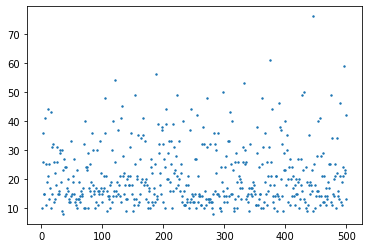

In [104]:
episodes = np.arange(1,len(performance)+1)
plt.scatter(episodes, performance, s=2)

In [105]:
render_test_episode(agent) 

# Advantage Actor-Critic - trajectory version

In [23]:
from importlib import reload
reload(agents)

<module 'agents' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/agents.py'>

In [24]:
class experience_buffer():
    def __init__(self, r_list, logp_list, s_list, done_list):
        self.r_list = r_list
        self.logp_list = logp_list
        self.s_list = s_list
        self.done_list = done_list
    
    def get_exp(self):
        L = np.min([len(r) for r in self.r_list])
        r_list_final = np.array([x[-L:] for x in self.r_list])
        logp_list_final = np.array([x[-L:] for x in self.logp_list])
        s_list_final = np.array([x[-L-1:] for x in self.s_list])
        done_list_final = np.array([x[-L:] for x in self.done_list])
        return r_list_final, logp_list_final, s_list_final, done_list_final

In [29]:
def train_cartpole_A2C_v1(n_epochs = 100, n_batches = 1, lr = 0.01, gamma = 0.99):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = agents.A2C_v1(observation_space, action_space, lr, gamma)
    performance = []
    for e in range(n_epochs):
        r_list = []
        logp_list = []
        s_list = []
        done_list = []
        score = []
        
        for b in range(n_batches):
            rewards, log_probs, states, done = play_episode(agent, env, return_states=True, greedy=False)
            r_list.append(rewards)
            logp_list.append(log_probs)
            s_list.append(states)
            done_list.append(done)
            score.append(np.sum(rewards))
            
        performance.append(np.mean(score))
        print("Epoch %d - mean reward: %.0f"%(e+1, performance[-1]))
        exp_buff = experience_buffer(r_list, logp_list, s_list, done_list)
        rewards, log_probs, states, done = exp_buff.get_exp()
        #print("rewards.shape ", rewards.shape)
        #print("log_probs.shape ", log_probs.shape)
        #print("states.shape ", states.shape)
        #print("done.shape ", done.shape)
        #print("done ", done)
        agent.update(rewards, log_probs, states, done)
        
    return agent, np.array(performance)

In [30]:
%%time
agent_v1, performance_v1 = train_cartpole_A2C_v1(n_epochs=500, lr=1e-4)

Epoch 1 - mean reward: 33
Epoch 2 - mean reward: 9
Epoch 3 - mean reward: 26
Epoch 4 - mean reward: 13
Epoch 5 - mean reward: 49
Epoch 6 - mean reward: 43
Epoch 7 - mean reward: 17
Epoch 8 - mean reward: 13
Epoch 9 - mean reward: 10
Epoch 10 - mean reward: 22
Epoch 11 - mean reward: 11
Epoch 12 - mean reward: 25
Epoch 13 - mean reward: 15
Epoch 14 - mean reward: 23
Epoch 15 - mean reward: 24
Epoch 16 - mean reward: 12
Epoch 17 - mean reward: 19
Epoch 18 - mean reward: 11
Epoch 19 - mean reward: 17
Epoch 20 - mean reward: 14
Epoch 21 - mean reward: 13
Epoch 22 - mean reward: 37
Epoch 23 - mean reward: 31
Epoch 24 - mean reward: 19
Epoch 25 - mean reward: 16
Epoch 26 - mean reward: 24
Epoch 27 - mean reward: 47
Epoch 28 - mean reward: 12
Epoch 29 - mean reward: 16
Epoch 30 - mean reward: 16
Epoch 31 - mean reward: 20
Epoch 32 - mean reward: 20
Epoch 33 - mean reward: 15
Epoch 34 - mean reward: 16
Epoch 35 - mean reward: 32
Epoch 36 - mean reward: 20
Epoch 37 - mean reward: 20
Epoch 38 - 

Epoch 303 - mean reward: 13
Epoch 304 - mean reward: 36
Epoch 305 - mean reward: 41
Epoch 306 - mean reward: 23
Epoch 307 - mean reward: 13
Epoch 308 - mean reward: 13
Epoch 309 - mean reward: 25
Epoch 310 - mean reward: 20
Epoch 311 - mean reward: 11
Epoch 312 - mean reward: 15
Epoch 313 - mean reward: 15
Epoch 314 - mean reward: 26
Epoch 315 - mean reward: 32
Epoch 316 - mean reward: 13
Epoch 317 - mean reward: 25
Epoch 318 - mean reward: 17
Epoch 319 - mean reward: 14
Epoch 320 - mean reward: 12
Epoch 321 - mean reward: 26
Epoch 322 - mean reward: 22
Epoch 323 - mean reward: 11
Epoch 324 - mean reward: 17
Epoch 325 - mean reward: 17
Epoch 326 - mean reward: 18
Epoch 327 - mean reward: 17
Epoch 328 - mean reward: 37
Epoch 329 - mean reward: 29
Epoch 330 - mean reward: 17
Epoch 331 - mean reward: 16
Epoch 332 - mean reward: 16
Epoch 333 - mean reward: 13
Epoch 334 - mean reward: 13
Epoch 335 - mean reward: 43
Epoch 336 - mean reward: 31
Epoch 337 - mean reward: 24
Epoch 338 - mean rew

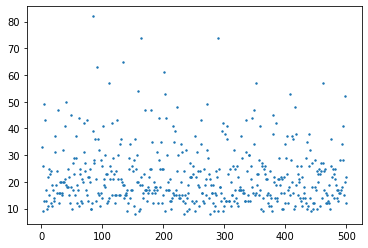

In [31]:
episodes = np.arange(1,len(performance_v1)+1)
plt.scatter(episodes, performance_v1, s=2)

In [32]:
render_test_episode(agent_v1) 

## Reward shaping

Try to make a more informative reward.
Idea: store the whole trajectory, then subtract $-\frac{eps \cdot t}{T}$ to all rewards, where $t$ is the step at which the reward was obtained and $T$ the total number of steps.

In [114]:
from importlib import reload
reload(agents)

<module 'agents' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/agents.py'>

In [115]:
def shape_rewards(r, eps, power=1):
    T = len(r)
    t = np.arange(1,T+1)
    r -= eps*(t/T)**power
    return r

In [116]:
def train_cartpole_A2C_v2(n_epochs = 100, n_batches = 1, lr = 0.01, gamma = 0.99, eps=1, power=1):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = agents.A2C_v1(observation_space, action_space, lr, gamma)
    performance = []
    for e in range(n_epochs):
        r_list = []
        logp_list = []
        s_list = []
        done_list = []
        score = []
        
        for b in range(n_batches):
            rewards, log_probs, states, done = play_episode(agent, env, return_states=True, greedy=False)
            if done[-1] == True:
                rewards = shape_rewards(rewards, eps, power)
            #print("rewards ", rewards)
            r_list.append(rewards)
            logp_list.append(log_probs)
            s_list.append(states)
            done_list.append(done)
            score.append(np.sum(rewards))
            
        performance.append(np.mean(score))
        if (e+1)%10 == 0:
            print("Epoch %d - mean reward: %.0f"%(e+1, np.mean(performance[-10:])))
        exp_buff = experience_buffer(r_list, logp_list, s_list, done_list)
        rewards, log_probs, states, done = exp_buff.get_exp()
        #print("rewards.shape ", rewards.shape)
        #print("log_probs.shape ", log_probs.shape)
        #print("states.shape ", states.shape)
        #print("done.shape ", done.shape)
        #print("done ", done)
        agent.update(rewards, log_probs, states, done)
        
    return agent, np.array(performance)

In [119]:
%%time
agent_v1, performance_v1 = train_cartpole_A2C_v2(n_epochs=5000, lr=5e-3, eps=1, power=2)

Epoch 10 - mean reward: 13
Epoch 20 - mean reward: 12
Epoch 30 - mean reward: 10
Epoch 40 - mean reward: 10
Epoch 50 - mean reward: 10
Epoch 60 - mean reward: 10
Epoch 70 - mean reward: 12
Epoch 80 - mean reward: 9
Epoch 90 - mean reward: 12
Epoch 100 - mean reward: 11
Epoch 110 - mean reward: 14
Epoch 120 - mean reward: 14
Epoch 130 - mean reward: 11
Epoch 140 - mean reward: 15
Epoch 150 - mean reward: 12
Epoch 160 - mean reward: 12
Epoch 170 - mean reward: 11
Epoch 180 - mean reward: 18
Epoch 190 - mean reward: 12
Epoch 200 - mean reward: 9
Epoch 210 - mean reward: 10
Epoch 220 - mean reward: 12
Epoch 230 - mean reward: 12
Epoch 240 - mean reward: 18
Epoch 250 - mean reward: 11
Epoch 260 - mean reward: 13
Epoch 270 - mean reward: 10
Epoch 280 - mean reward: 10
Epoch 290 - mean reward: 17
Epoch 300 - mean reward: 15
Epoch 310 - mean reward: 11
Epoch 320 - mean reward: 11
Epoch 330 - mean reward: 15
Epoch 340 - mean reward: 10
Epoch 350 - mean reward: 13
Epoch 360 - mean reward: 14
Epo

Epoch 2880 - mean reward: 11
Epoch 2890 - mean reward: 12
Epoch 2900 - mean reward: 17
Epoch 2910 - mean reward: 16
Epoch 2920 - mean reward: 19
Epoch 2930 - mean reward: 14
Epoch 2940 - mean reward: 15
Epoch 2950 - mean reward: 15
Epoch 2960 - mean reward: 17
Epoch 2970 - mean reward: 11
Epoch 2980 - mean reward: 14
Epoch 2990 - mean reward: 10
Epoch 3000 - mean reward: 12
Epoch 3010 - mean reward: 13
Epoch 3020 - mean reward: 10
Epoch 3030 - mean reward: 12
Epoch 3040 - mean reward: 11
Epoch 3050 - mean reward: 13
Epoch 3060 - mean reward: 10
Epoch 3070 - mean reward: 10
Epoch 3080 - mean reward: 10
Epoch 3090 - mean reward: 15
Epoch 3100 - mean reward: 15
Epoch 3110 - mean reward: 11
Epoch 3120 - mean reward: 12
Epoch 3130 - mean reward: 16
Epoch 3140 - mean reward: 14
Epoch 3150 - mean reward: 14
Epoch 3160 - mean reward: 14
Epoch 3170 - mean reward: 14
Epoch 3180 - mean reward: 9
Epoch 3190 - mean reward: 10
Epoch 3200 - mean reward: 12
Epoch 3210 - mean reward: 13
Epoch 3220 - me

# Entropy-regularized Policy-Gradient 

Problem: if the agent takes a dumb action with 100% probability it won't be penalized, since log(1)=0.

Idea: add -Entropy of the action's distribution in order to make it less likely to have such a strong policy.

In [169]:
from importlib import reload
reload(agents)

<module 'agents' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/agents.py'>

In [180]:
def play_episode_ent(agent, env, return_states=False, greedy=True):
    # Reset environment (start of an episode)
    state = env.reset()
    rewards = []
    log_probs = []
    distributions = []
    done = []
    
    if return_states:
        states = [state]
        
    steps = 0
    while True:
        action, log_prob, prob_distr = agent.get_action(state, return_log = True, greedy=greedy)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        
        if return_states:
            states.append(new_state)
            
        #if terminal and 'TimeLimit.truncated' not in info:
        #    reward = -1
            
        rewards.append(reward)
        log_probs.append(log_prob)
        distributions.append(prob_distr)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
       
    rewards = np.array(rewards)
    log_probs = np.array(log_probs)
    #distributions = np.array(distributions)
    done = np.array(done)
    
    if return_states:
        return rewards, log_probs, np.array(states), distributions, done
    else:
        return rewards, log_probs, distributions, done

In [181]:
def train_cartpole_entropy(n_episodes = 100, lr = 0.01, gamma = 0.99, H=1e-3, greedy=False):
    # Create environment
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    # Init agent
    agent = agents.PolicyGradEnt(observation_space, action_space, lr, gamma, H)
    performance = []
    losses = []
    steps_log = []
    for e in range(n_episodes):
        rewards, log_probs, distributions, _ = play_episode_ent(agent, env, greedy=greedy)
        steps_log.append(len(rewards))
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.0f"%(e+1, np.mean(performance[-10:])))
        
        loss = agent.update(rewards, log_probs, distributions)
        losses.append(loss)
    return agent, np.array(performance), np.array(losses), np.array(steps_log)

In [182]:
%%time
trained_agentPG, cumulative_rewardPG, lossesPG, steps_log = train_cartpole_entropy(n_episodes = 500, lr=5e-3, H=1e-3)

Episode 10 - reward: 22
Episode 20 - reward: 18
Episode 30 - reward: 18
Episode 40 - reward: 19
Episode 50 - reward: 20
Episode 60 - reward: 18
Episode 70 - reward: 20
Episode 80 - reward: 17
Episode 90 - reward: 19
Episode 100 - reward: 23
Episode 110 - reward: 33
Episode 120 - reward: 35
Episode 130 - reward: 43
Episode 140 - reward: 88
Episode 150 - reward: 105
Episode 160 - reward: 204
Episode 170 - reward: 398
Episode 180 - reward: 406
Episode 190 - reward: 432
Episode 200 - reward: 378
Episode 210 - reward: 425
Episode 220 - reward: 500
Episode 230 - reward: 500
Episode 240 - reward: 417
Episode 250 - reward: 372
Episode 260 - reward: 424
Episode 270 - reward: 464
Episode 280 - reward: 317
Episode 290 - reward: 73
Episode 300 - reward: 83
Episode 310 - reward: 172
Episode 320 - reward: 467
Episode 330 - reward: 500
Episode 340 - reward: 500
Episode 350 - reward: 472
Episode 360 - reward: 414
Episode 370 - reward: 390
Episode 380 - reward: 399
Episode 390 - reward: 406
Episode 400

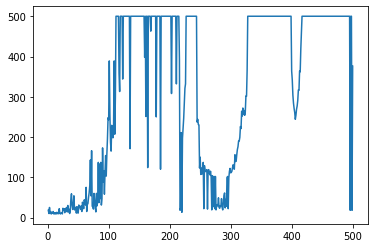

In [173]:
episodes = np.arange(1,len(cumulative_rewardPG)+1)
plt.plot(episodes, cumulative_rewardPG)
plt.show()

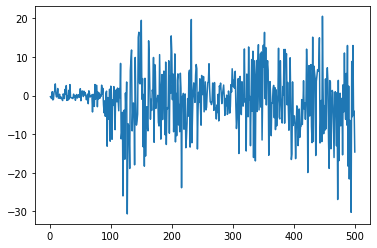

In [176]:
plt.plot(episodes, lossesPG)
plt.show()